Выполним необходимые импорты

In [32]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

Выполним загрузку датасета [Oxford-IIIT Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [33]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True)
train_dataset_orig, test_dataset_orig = dataset['train'], dataset['test']

num_classes = info.features['label'].num_classes
print("Total number of classes:", num_classes)

class_names = info.features['label'].names
print("Class names:", class_names)

Total number of classes: 37
Class names: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


Вынесем некоторые часто используемые константы

In [34]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 7

Выполним подготовку датасета для подачи его в соответствующие предобученные модели

In [35]:
def prepare_dataset(dataset, model_name, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False):
    preprocess_map = {
        'vgg16': tf.keras.applications.vgg16.preprocess_input,
        'vgg19': tf.keras.applications.vgg19.preprocess_input,
        'resnet50': tf.keras.applications.resnet50.preprocess_input
    }

    preprocess_fn = preprocess_map[model_name]

    def format_image(image, label):
        image = tf.image.resize(image, img_size)
        image = preprocess_fn(image)
        return image, label

    ds = dataset.map(format_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1024)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


Подготовим train и test выборки для VGG16

In [36]:
train_vgg16 = prepare_dataset(train_dataset_orig, model_name='vgg16', batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=True)
test_vgg16 = prepare_dataset(test_dataset_orig, model_name='vgg16', batch_size=BATCH_SIZE, img_size=IMG_SIZE)

In [37]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

def build_vgg16(num_classes=37, input_shape=(*IMG_SIZE,3), train_base=False):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    if not train_base:
        for layer in base_model.layers:
            layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model_vgg16 = build_vgg16(num_classes=num_classes, train_base=False)
model_vgg16.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 37)                  │           4,773 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,175,141 (80.78 MB)

 Trainable params: 6,460,453 (24.64 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Обучим модель

In [38]:
history_vgg16 = model_vgg16.fit(
    train_vgg16,
    validation_data=test_vgg16,
    epochs=EPOCHS
)

Epoch 1/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 79s 539ms/step - accuracy: 0.2856 - loss: 12.4940 - val_accuracy: 0.5356 - val_loss: 3.4204
Epoch 2/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 350ms/step - accuracy: 0.7713 - loss: 1.3445 - val_accuracy: 0.5980 - val_loss: 2.9715
Epoch 3/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 351ms/step - accuracy: 0.9035 - loss: 0.4972 - val_accuracy: 0.6511 - val_loss: 2.9639
Epoch 4/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 43s 341ms/step - accuracy: 0.9336 - loss: 0.3083 - val_accuracy: 0.6604 - val_loss: 2.9613
Epoch 5/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 83s 350ms/step - accuracy: 0.9541 - loss: 0.2153 - val_accuracy: 0.6841 - val_loss: 3.2886
Epoch 6/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 45s 351ms/step - accuracy: 0.9529 - loss: 0.2587 - val_accuracy: 0.6980 - val_loss: 3.0205
Epoch 7/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 81s 353ms/step - accuracy: 0.9659 - loss: 0.1902 - val_accuracy: 0.7155 - val_loss: 2.9620


Выполним построение accuracy на обучении и валидации для VGG16

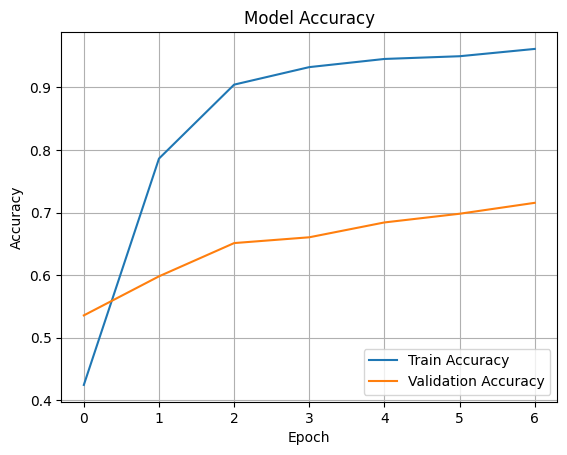

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Подготовим train и test выборки для VGG19

In [40]:
train_vgg19 = prepare_dataset(train_dataset_orig, model_name='vgg19', batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=True)
test_vgg19 = prepare_dataset(test_dataset_orig, model_name='vgg19', batch_size=BATCH_SIZE, img_size=IMG_SIZE)

In [41]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models

def build_vgg19(num_classes=37, input_shape=(*IMG_SIZE,3), train_base=False):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    if not train_base:
        for layer in base_model.layers:
            layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model_vgg19 = build_vgg19(num_classes=num_classes, train_base=False)
model_vgg19.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

model_vgg19.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 37)                  │           4,773 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,484,837 (101.03 MB)

 Trainable params: 6,460,453 (24.64 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Обучим модель

In [42]:
history_vgg19 = model_vgg19.fit(
    train_vgg19,
    validation_data=test_vgg19,
    epochs=EPOCHS
)

Epoch 1/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 56s 431ms/step - accuracy: 0.2928 - loss: 10.9334 - val_accuracy: 0.5429 - val_loss: 2.6215
Epoch 2/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 52s 418ms/step - accuracy: 0.7472 - loss: 1.2955 - val_accuracy: 0.6539 - val_loss: 2.0951
Epoch 3/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 52s 417ms/step - accuracy: 0.8843 - loss: 0.4963 - val_accuracy: 0.6814 - val_loss: 2.1947
Epoch 4/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 99s 568ms/step - accuracy: 0.9342 - loss: 0.2433 - val_accuracy: 0.6852 - val_loss: 2.4330
Epoch 5/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 567ms/step - accuracy: 0.9469 - loss: 0.2771 - val_accuracy: 0.6991 - val_loss: 2.5876
Epoch 6/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 65s 422ms/step - accuracy: 0.9476 - loss: 0.3298 - val_accuracy: 0.7010 - val_loss: 2.8254
Epoch 7/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 415ms/step - accuracy: 0.9640 - loss: 0.1526 - val_accuracy: 0.7005 - val_loss: 2.9746


Выполним построение accuracy на обучении и валидации для VGG19

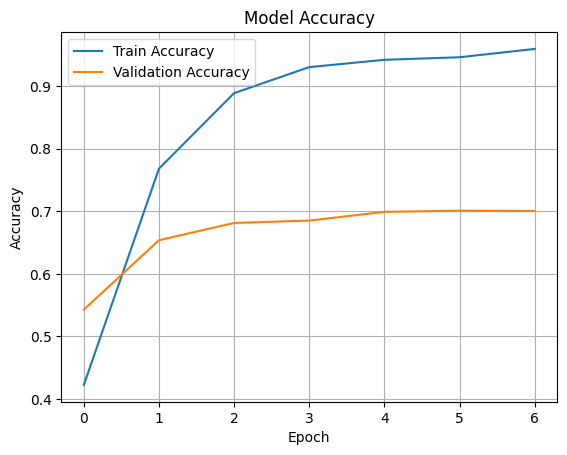

In [43]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_vgg19.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg19.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Подготовим train и test выборки для ResNet

In [44]:
train_resnet = prepare_dataset(train_dataset_orig, model_name='resnet50', batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=True)
test_resnet = prepare_dataset(test_dataset_orig, model_name='resnet50', batch_size=BATCH_SIZE, img_size=IMG_SIZE)

In [45]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

def build_resnet50(num_classes=37, input_shape=(*IMG_SIZE,3), train_base=False):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    if not train_base:
        for layer in base_model.layers:
            layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model_resnet50 = build_resnet50(num_classes=num_classes, train_base=False)
model_resnet50.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

model_resnet50.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 37)                  │           4,773 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,315,749 (188.12 MB)

 Trainable params: 25,728,037 (98.14 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Обучение модели

In [46]:
history_resnet50 = model_resnet50.fit(
    train_resnet,
    validation_data=test_resnet,
    epochs=EPOCHS
)

Epoch 1/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 48s 300ms/step - accuracy: 0.3333 - loss: 6.8415 - val_accuracy: 0.7059 - val_loss: 1.2390
Epoch 2/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 301ms/step - accuracy: 0.9037 - loss: 0.3872 - val_accuracy: 0.7547 - val_loss: 1.4018
Epoch 3/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 42s 300ms/step - accuracy: 0.9511 - loss: 0.1554 - val_accuracy: 0.7247 - val_loss: 1.8326
Epoch 4/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 247ms/step - accuracy: 0.9724 - loss: 0.1179 - val_accuracy: 0.7591 - val_loss: 1.5532
Epoch 5/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 300ms/step - accuracy: 0.9855 - loss: 0.0580 - val_accuracy: 0.7397 - val_loss: 2.2254
Epoch 6/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.9729 - loss: 0.1014 - val_accuracy: 0.7724 - val_loss: 1.7423
Epoch 7/7
115/115 ━━━━━━━━━━━━━━━━━━━━ 32s 246ms/step - accuracy: 0.9784 - loss: 0.0758 - val_accuracy: 0.7473 - val_loss: 2.3349


Выполним построение accuracy на обучении и валидации для ResNet

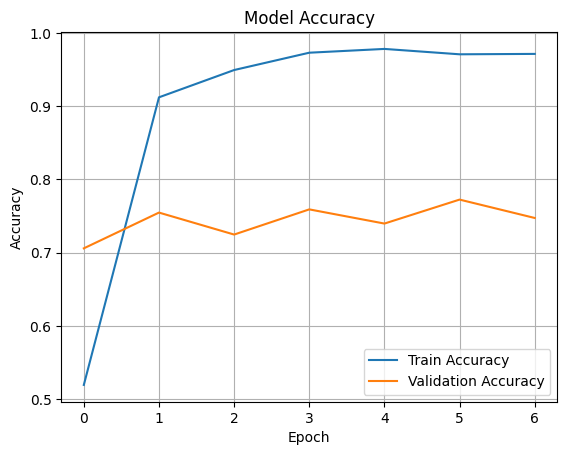

In [47]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_resnet50.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Оценим финальное качество каждой модели

In [48]:
test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(test_vgg16)
test_loss_vgg19, test_acc_vgg19 = model_vgg19.evaluate(test_vgg19)
test_loss_resnet50, test_acc_resnet50 = model_resnet50.evaluate(test_resnet)

print("VGG16 Accuracy:", test_acc_vgg16)
print("VGG19 Accuracy:", test_acc_vgg19)
print("ResNet50 Accuracy:", test_acc_resnet50)

115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.7228 - loss: 3.0610
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 205ms/step - accuracy: 0.7172 - loss: 2.7965
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.7493 - loss: 2.1883
VGG16 Accuracy: 0.7154538035392761
VGG19 Accuracy: 0.7004633545875549
ResNet50 Accuracy: 0.747342586517334


Лучшая модель

In [49]:
best_model = model_resnet50

In [50]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal',
               'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel',
               'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond',
               'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug',
               'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese',
               'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

cat_breeds = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian',
              'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx']

cat_indices = [class_names.index(breed) for breed in cat_breeds]

y_true, y_pred, y_prob = [], [], []

for batch in test_resnet:
    images, labels = batch
    preds = model_resnet50.predict(images)
    y_prob.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Accuracy бинарной классификации "Cat vs Dog"

In [51]:
true_is_cat = np.isin(y_true, cat_indices)
pred_is_cat = np.isin(y_pred, cat_indices)
binary_accuracy = accuracy_score(true_is_cat, pred_is_cat)
print("Binary (Cat vs Dog) accuracy:", binary_accuracy)

Binary (Cat vs Dog) accuracy: 0.967566094303625


Построим confusion матрицу

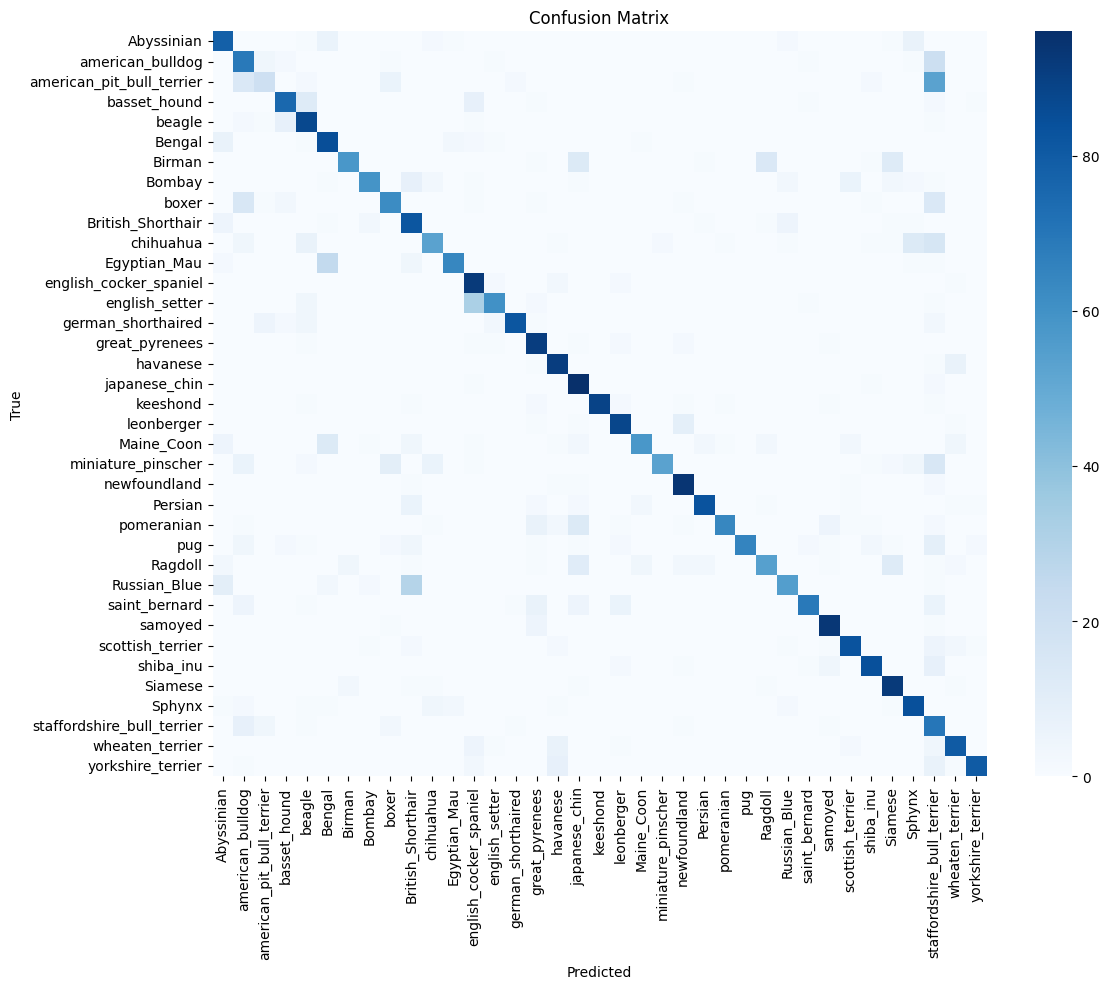

In [52]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

Посчитаем Top-3 и Top-5 accuracy

In [53]:
top_3 = top_k_accuracy_score(y_true, y_prob, k=3)
print("Top-3 accuracy:", top_3)

top_5 = top_k_accuracy_score(y_true, y_prob, k=5)
print("Top-5 accuracy:", top_5)

Top-3 accuracy: 0.9024257290814935
Top-5 accuracy: 0.9484873262469338


Выполним визуализацию зон интереса, на которые смотрит нейросети. Воспользуемся [GradCam](https://keras.io/examples/vision/grad_cam/)

GradCam модель

In [54]:
base_model = model_resnet50.layers[0]
last_conv_layer = base_model.get_layer("conv5_block2_out")

grad_model = tf.keras.Model(
    inputs=base_model.input,
    outputs=[last_conv_layer.output, base_model.output]
)

Построим heat map

In [55]:
def make_gradcam_heatmap(img_tensor, pred_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, base_output = grad_model(img_tensor)
        tape.watch(conv_outputs)

        x = model_resnet50.layers[1](base_output)
        x = model_resnet50.layers[2](x)
        x = model_resnet50.layers[3](x)
        preds = model_resnet50.layers[4](x)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Наложение heat map на изображение

In [56]:
def overlay_heatmap(heatmap, original_image, alpha=0.5, colormap_name='jet'):
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (original_image.shape[0], original_image.shape[1])).numpy()
    heatmap = np.squeeze(heatmap)
    heatmap = np.clip(heatmap, 0, 1)
    colormap = cm.get_cmap(colormap_name)
    heatmap_colored = colormap(heatmap)[:, :, :3]
    original = original_image.astype("float32") / 255.0
    overlay = original * (1 - alpha) + heatmap_colored * alpha
    return np.uint8(np.clip(overlay * 255, 0, 255))

In [57]:
IMAGES_FOR_HEAT_MAP = 20

selected_images = []
selected_labels = []

for i, (img_batch, label_batch) in enumerate(test_dataset_orig):
    selected_images.append(img_batch.numpy())
    selected_labels.append(int(label_batch.numpy()))
    if len(selected_images) == IMAGES_FOR_HEAT_MAP:
        break

Выполним визуализацию

<ipython-input-56-f2ff901ea25a>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap(colormap_name)


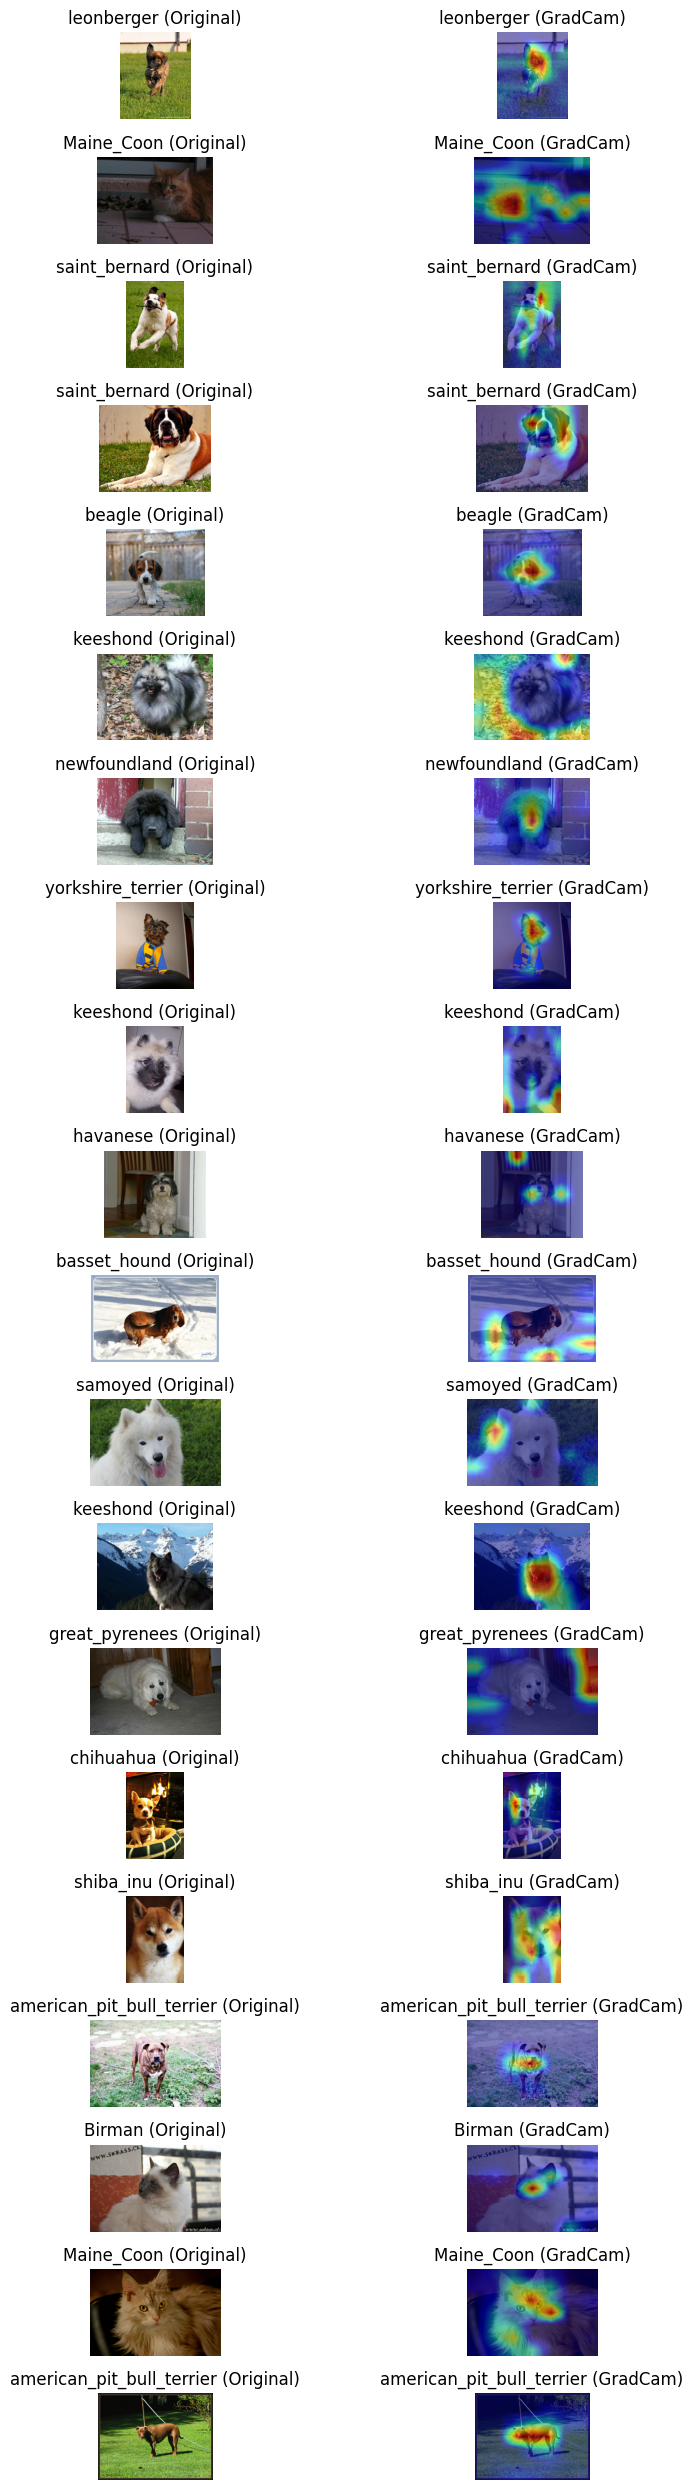

In [58]:
import matplotlib.cm as cm

plt.figure(figsize=(10, 25))

for i in range(IMAGES_FOR_HEAT_MAP):
    original = selected_images[i]
    label = selected_labels[i]
    class_name = class_names[label]

    input_img = tf.image.resize(original, IMG_SIZE)
    input_img = tf.keras.applications.resnet50.preprocess_input(input_img)
    input_tensor = tf.expand_dims(input_img, axis=0)

    heatmap = make_gradcam_heatmap(input_tensor)
    overlay = overlay_heatmap(heatmap, original, alpha=0.5, colormap_name='jet')

    plt.subplot(IMAGES_FOR_HEAT_MAP, 2, i * 2 + 1)
    plt.imshow(original.astype("uint8"))
    plt.title(f"{class_name} (Original)")
    plt.axis("off")

    plt.subplot(IMAGES_FOR_HEAT_MAP, 2, i * 2 + 2)
    plt.imshow(overlay)
    plt.title(f"{class_name} (GradCam)")
    plt.axis("off")

plt.tight_layout()
plt.show()

Обучить автоэнкодер восстанавливать изображения животных из датасета Oxford Pets, уменьшая их в размер и снова восстанавливая

Вынесем некоторые константы

In [62]:
IMG_SIZE_GEN = (128, 128)
BATCH_SIZE_GEN = 32
EPOCHS_GEN = 10

Подготовка датасета

In [63]:
def prepare_autoencoder_dataset(dataset, img_size=IMG_SIZE_GEN, batch_size=BATCH_SIZE_GEN):
    def format_image(image, _):
        image = tf.image.resize(image, img_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image, image

    ds = dataset.map(format_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_auto = prepare_autoencoder_dataset(train_dataset_orig)
test_auto = prepare_autoencoder_dataset(test_dataset_orig)

Построим сверточный автоэнкодер

In [64]:
from tensorflow.keras import layers, models

def build_autoencoder(input_shape=(*IMG_SIZE_GEN, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2,2), padding='same')(x)

    x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(encoded)
    x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
    decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(inputs, decoded)
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

Обучение автоэнкодера

In [65]:
history_auto = autoencoder.fit(train_auto, validation_data=test_auto, epochs=EPOCHS_GEN)

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 157ms/step - loss: 0.0434 - val_loss: 0.0094
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - loss: 0.0077 - val_loss: 0.0071
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 10/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - loss: 0.0041 - val_loss: 0.0044


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


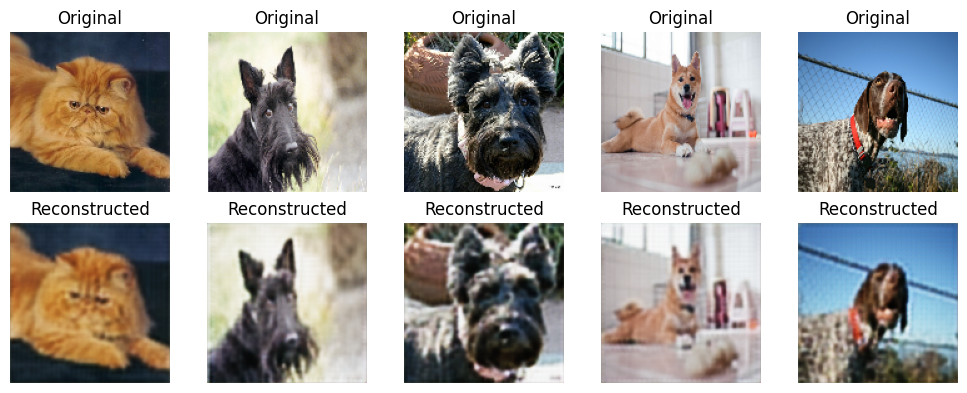

In [66]:
def display_autoencoder_results(model, dataset, n=5):
    for batch in dataset.take(1):
        images, _ = batch
        reconstructed = model.predict(images)

        plt.figure(figsize=(10, 4))
        for i in range(n):
            plt.subplot(2, n, i+1)
            plt.imshow(images[i])
            plt.title("Original")
            plt.axis("off")

            plt.subplot(2, n, n+i+1)
            plt.imshow(reconstructed[i])
            plt.title("Reconstructed")
            plt.axis("off")

        plt.tight_layout()

        plt.show()

display_autoencoder_results(autoencoder, test_auto)